# Chapter 12: A Deep Dive into Stable Diffusion

This chapter covers:

* How Stable Diffusion works
* Differences between Stable Diffusion and the latent diffusion model
* Various components of Stable Diffusion and their roles in text-to-image generation
* The K linear multi-step (K-LMS) noise scheduler

Stable Diffusion is based on the latent diffusion model (LDM) that we discussed in the previous chapter. It's one of the state-of-the-art text-to-image models, along with OpenAI's DALL-E 2 and Google's Imagen. However, Stable Diffusion is the only one that is open-sourced and free for anyone to use.

Stable Diffusion is developed by researchers from CompVis, Stability AI and LAION. It's largely based on the 2022 paper by Rombach et al. (High-Resolution Image Synthesis with Latent Diffusion Models, https://arxiv.org/abs/2112.10752). Stable Diffusion has incorporated several improvements and additional features. Here, we highlight a couple of notable differences. First, Stable Diffusion uses improved training techniques and optimizations, which lead to better stability and performance, further enhancing the quality of generated images. Second, while the LDM in the 2022 paper was trained on the LAION-400M dataset (with 400 million image-text pairs), Stable Diffusion was trained on a subset of an even larger dataset, the LAION-5B database (with 5 billion image-text pairs). Finally, Stable Diffusion has developed user-friendly applications and interfaces, democratizing access to high-quality generative models. These tools enable users without deep technical expertise to have access to the power of diffusion models.

In this chapter, you'll learn how to use Stable Diffusion to generate high-quality images through text prompts by using the Hugging Face diffusers library. We'll first discuss how to generate images using out-of-the-box tools. We then dive deep into the model and look at how various components in Stable Diffusion work. These components include the variational autoencoder (VAE), the noise scheduler, the denoising U-Net, the CLIP text encoder, and the CLIP image encoder. Instead of treating Stable Diffusion as a black box, you'll look under the hood and see how each component of the model contributes to the text-to-image generation process. Further, instead of observing just the final output, you'll witness the intermediate steps of the image generation process, starting from random noise in the latent space, to refined noisy latent images, to the final decoded high-resolution images. 

# 1. Generate Images with Stable Diffusion
In this section, you'll learn how to produce high resolution images by using a version of the Stable Diffusion that's integrated into the Hugging Face diffusers library.

## 1.1 Off the Shelf Stable Diffusion Model
The StableDiffusionPipeline package in the diffusers library allows you to use Stable Diffusion as an off-the-shelf tool to generate great images in just a few lines of code.

Let's use the prompt "an astronaut in a spacesuit riding a unicorn" to generate an image:

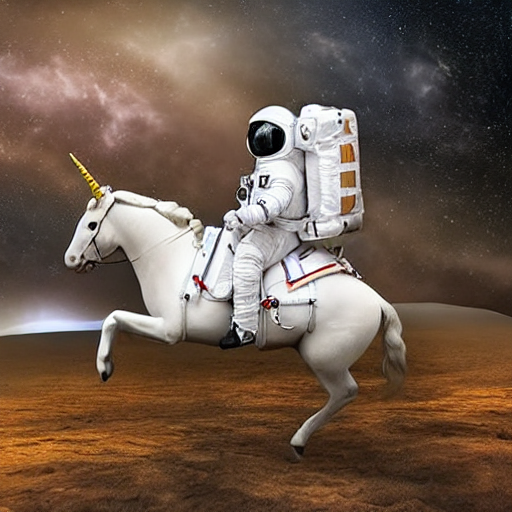

In [1]:
import torch
from diffusers import StableDiffusionPipeline

torch.manual_seed(42)
prompt="an astronaut in a spacesuit riding a unicorn"
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    variant="fp16",
    torch_dtype=torch.float16, 
    use_auth_token=True).to("cuda")
image = pipe(prompt).images[0]
image.save(f"files/{prompt}.png")
image

The image clearly shows an astronaut riding a unicorn. 

The from_pretrained() method in the StableDiffusionPipeline package loads the weights of the Stable Diffusion model. There are different versions of the model available and the details are on Hugging Face here https://huggingface.co/CompVis/stable-diffusion. 

We choose the version stable-diffusion-v1-4. The first time you use it, Python downloads the pretrained weights to your computer. Since the weights are large (more than 1GB), we'll use this version for all examples in this chapter. If you use a different version of the pretained model, simply change the version name in the code cell. 

The arguments variant="fp16" and torch_dtype=torch.float16 mean that we are using the half-precision branch of the pretrained model. The default data type in PyTorch tensors is float32, a 32-bit floating-point number. A half-precision floating-point number, 
flo16, provides less precise results than float32, but it takes less time to compute, thereby speeding up the image generation process. 

We have fixed the random state in PyTorch so results are reproducible. Further, you can generate multiple results at once. Here we generate three images using a list of three prompts:

  0%|          | 0/50 [00:00<?, ?it/s]

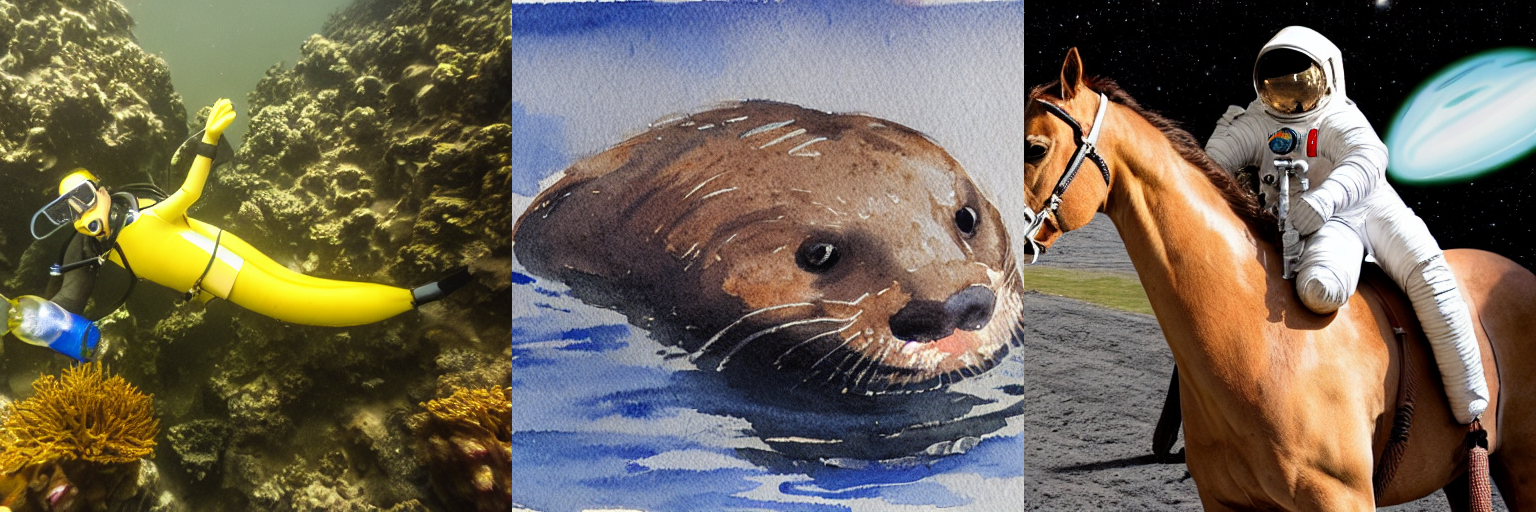

In [2]:
from PIL import Image

torch.manual_seed(42)
prompts = ["a banana scuba diving",
    "a watercolor painting of an otter",
    "a photograph of an astronaut riding a horse"] 
images = pipe(prompts).images
grid = Image.new('RGB', size=(3*images[0].size[0],
                  images[0].size[1]))
for i, img in enumerate(images):
    grid.paste(img, box=(i*images[0].size[0], 0))
grid.save("three_prompts.png")
grid

## 1.2 Adjusting Resolution and the Classifier Free Guidance
Now that you understand how to use the StableDiffusionPipeline in the diffusers library as an off-the-shelf tool, let's explore some variations of the tool. 

For example, the default resolution of the generated image is 512x512. However, you can change it to a different resolution. Further, we can adjust the degree of classifier free guidance by changing the parameter value in the guidance_scale parameter.

  0%|          | 0/50 [00:00<?, ?it/s]

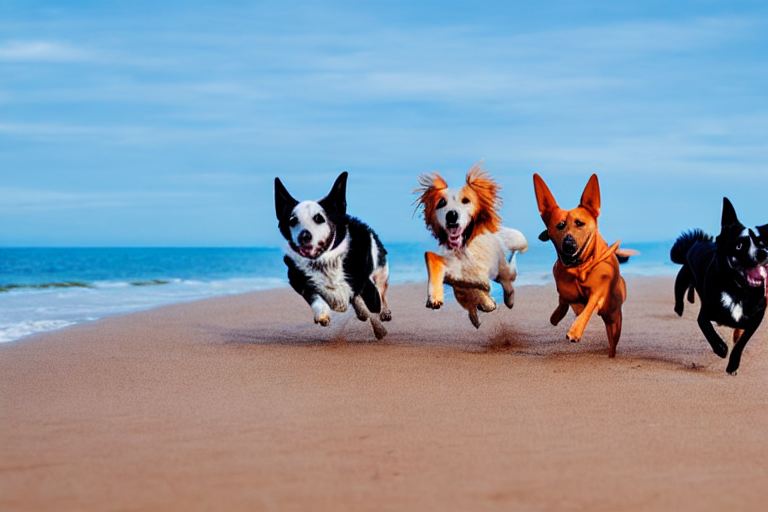

In [3]:
torch.manual_seed(42)
prompt = "dogs running on a sandy beach under blue sky" 
images = pipe(prompt,width=768,height=512,
             guidance_scale=12).images
images[0].save(f"files/{prompt}.png")
images[0]

The output shows four dogs running on a sandy beach under a blue sky. The generation takes just 9 seconds. 

# 2. Understand Different Parts of Stable Diffusion
For the rest of this chapter, we'll discuss various parts of the Stable Diffusion. Specifically, we'll discuss (1) The text encoder; (2) The k-LMS noise scheduler; (3) The denoising U-Net; (4) the VAE decoder. 

We'll discuss the text encoder in detail in this section. 

## 2.1 Define Hyperparameters for the Model
We first create a Config() class to store all the hyperparameters used in the model.

In [4]:
class Config:
    height = 512                        
    width = 512                               
    guidance_scale = 12                
    rows=2
    cols=3
    seed=42
    num_inference_steps=50
    prompts = ["a little girl walking on green grass",
        "an image of a water butterfly",
        "a master Jedi tiger with a light sabre in hands",
        "an underwater fantasy city",
        "dogs running on a sunny beach",
        "a lady in sunglasses riding a motorcycle"] 
config=Config()

The height and width of the generated images are 512 pixels. We'll use 50 inference steps. The classifier free guidance scale is set at 12 and this parameter is usually set between 8 and 14. We'll generate six images, plotted in 2 rows and 3 columns. Make sure that the number of prompts equals the number of images in the image grid. We can use the assert command to check:

In [5]:
assert config.rows*config.cols==len(config.prompts), '''make sure
the number of images in the grid matches the number of prompts'''

## 2.2 A Text Encoder to Process the Prompt
The first step in text-to-image generation is to convert the text prompts to text embeddings. These embeddings are used as the conditioning factors when generating latent images. 

We'll use the trained CLIP text-encoder to transform the text prompts into text embeddings that can be understood by the denoising U-Net model. We import the trained CLIP encoder from the transformers library:

In [6]:
from transformers import CLIPTextModel, CLIPTokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14").to(device)

Now we can tokenize the text prompts into a sequence of indexes:

In [7]:
tokens=tokenizer(config.prompts,padding="max_length", 
              max_length=tokenizer.model_max_length, 
              truncation=True, return_tensors="pt")

We can now generate text embeddings.

In [8]:
torch.manual_seed(config.seed)
with torch.no_grad():
    text_embeddings=text_encoder(tokens.input_ids.to(device))[0]

We also obtain the unconditional text embeddings for classifier-free guidance.

In [9]:
uncond_input = tokenizer([""] * len(config.prompts), 
             padding="max_length", 
             max_length=tokenizer.model_max_length, 
             return_tensors="pt")
with torch.no_grad():
    uncond_embeds=text_encoder(
        uncond_input.input_ids.to(device))[0]  

We'll concatenate the unconditional text embedding and the prompt text embeddings to form the final text embeddings. 

In [10]:
text_embeddings=torch.cat([uncond_embeds, text_embeddings])

# 3 Image Generation in the Latent Space
As we discussed in the last chapter, the diffusion process is conducted in the latent space to speed up training. The images we are trying to generate are too large, with 3x512x512=786432 pixels. We therefore conduct diffusion in the latent space, with an image shape of (4, 64, 64). This reduces the image size by 48 times. 

In this section, you'll first import the noise scheduler and the trained denoising U-Net. You'll then start with pure noise and iteratively denoise the noisy images until they become clean images in the latent space. 

# 3.1 The K-LMS Noise Scheduler
The K-LMS (linear multi-step) scheduler is a type of sampling scheduler used in the context of the K-Diffusion model, a framework for generative models like those used in image synthesis and text generation. K-Diffusion models, such as those employed in Stable Diffusion, use diffusion processes to progressively transform noise into coherent data samples.

The linear multi-step (LMS) methods are a class of numerical solvers for differential equations, which are integral to diffusion models. They aim to estimate the value of the solution at a new point by using a linear combination of previously computed points. This makes LMS methods well-suited for modeling the iterative nature of diffusion processes. In diffusion models, the goal is to learn a reverse diffusion process that starts from pure noise and progressively denoises it to generate realistic samples. The K-Diffusion model incorporates a series of steps, each refining the generated sample further. The K-LMS scheduler specifically focuses on efficiently handling these iterative steps. 

We can import the LMSDiscreteScheduler() class from the diffusers library. 

In [11]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085,
                     beta_end=0.012, 
                     beta_schedule="scaled_linear", 
                     num_train_timesteps=1000)
scheduler.set_timesteps(config.num_inference_steps)

## 3.2 Image Generation with the Denoising U-Net
We'll import the trained denoising U-Net model from the diffusers library.

In [12]:
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet")
unet = unet.to(device)

We'll start with pure noise tensors. These noise tensors have the same shape as the final clean image in the latent space, (4, 64, 64). 

In [13]:
latents = torch.randn((len(config.prompts), 
           unet.config.in_channels, 
       config.height // 8, config.width // 8)).to(device)
latents = latents * scheduler.init_noise_sigma 

We'll gradually denoise the noisy images in the latent space, for 50 inference steps.

In [14]:
from tqdm import tqdm

with torch.autocast(device):  
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(
            latent_model_input, t)
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, 
              encoder_hidden_states=text_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred=noise_pred_uncond+config.guidance_scale*(
            noise_pred_text - noise_pred_uncond)
        latents = scheduler.step(noise_pred,
                                 t, latents).prev_sample

100it [10:10,  6.10s/it]


# 4. Convert Latent Images to High-Resolution Images with the trained VAE
We'll use the trained VAE to convert the low-resolution images in the latent space to high-resolution images as the final output of the Stable Diffusion model. 

## 4.1 Import the Trained VAE
We'll import the trained VAE from the diffusers library.

In [15]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained(
      "CompVis/stable-diffusion-v1-4", 
      subfolder="vae").to(device)

Now, we can convert the latent images to high resolution images. 

In [16]:
print(f"the size of the latents is {latents.shape}")
latents = 1 / 0.18215 * latents
with torch.no_grad():
    images = vae.decode(latents).sample
print(f"the size after VAE decoding is {images.shape}")    

the size of the latents is torch.Size([6, 4, 64, 64])
the size after VAE decoding is torch.Size([6, 3, 512, 512])


The results above say that "the size of the latents is torch.Size([6, 4, 64, 64])": there are six latent images, each with a shape of 4x64x64. The results also say that "the size after VAE decoding is torch.Size([6, 3, 512, 512])": there are six high-resolution images after VAE decoding, each with a shape of 3x512x512. There are three color channels in each image (RGB) and the width and height of the images are both 512 pixels. 

## 4.2 Visualize Latent Images and the Final High-Resolution Images
We can plot both the latent images and the final high-resolution images in two rows and three columns. 

Let's first plot the latent images. 

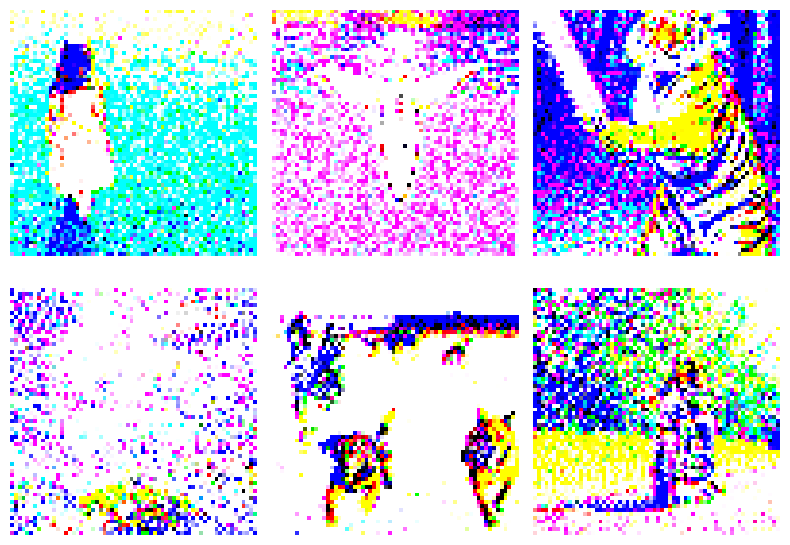

In [17]:
import matplotlib.pyplot as plt
import numpy as np 
 
plt.figure(figsize=(8,6),dpi=100)
for i in range(config.rows):
    for j in range(config.cols):
        plt.subplot(config.rows,config.cols,i*config.cols+j+1)
        im=latents[i*config.cols+j].permute(
            1,2,0).clamp(-1,1).detach().cpu()
        plt.imshow(im/2+0.5)    
        plt.axis('off')
plt.tight_layout()
plt.show()

Now we can visualize the high-resolution final images.

The images have high resolutions and match the text descriptions. You can experiment with various hyperparameters such as the guidance scale parameter, number of inference steps and so on. 

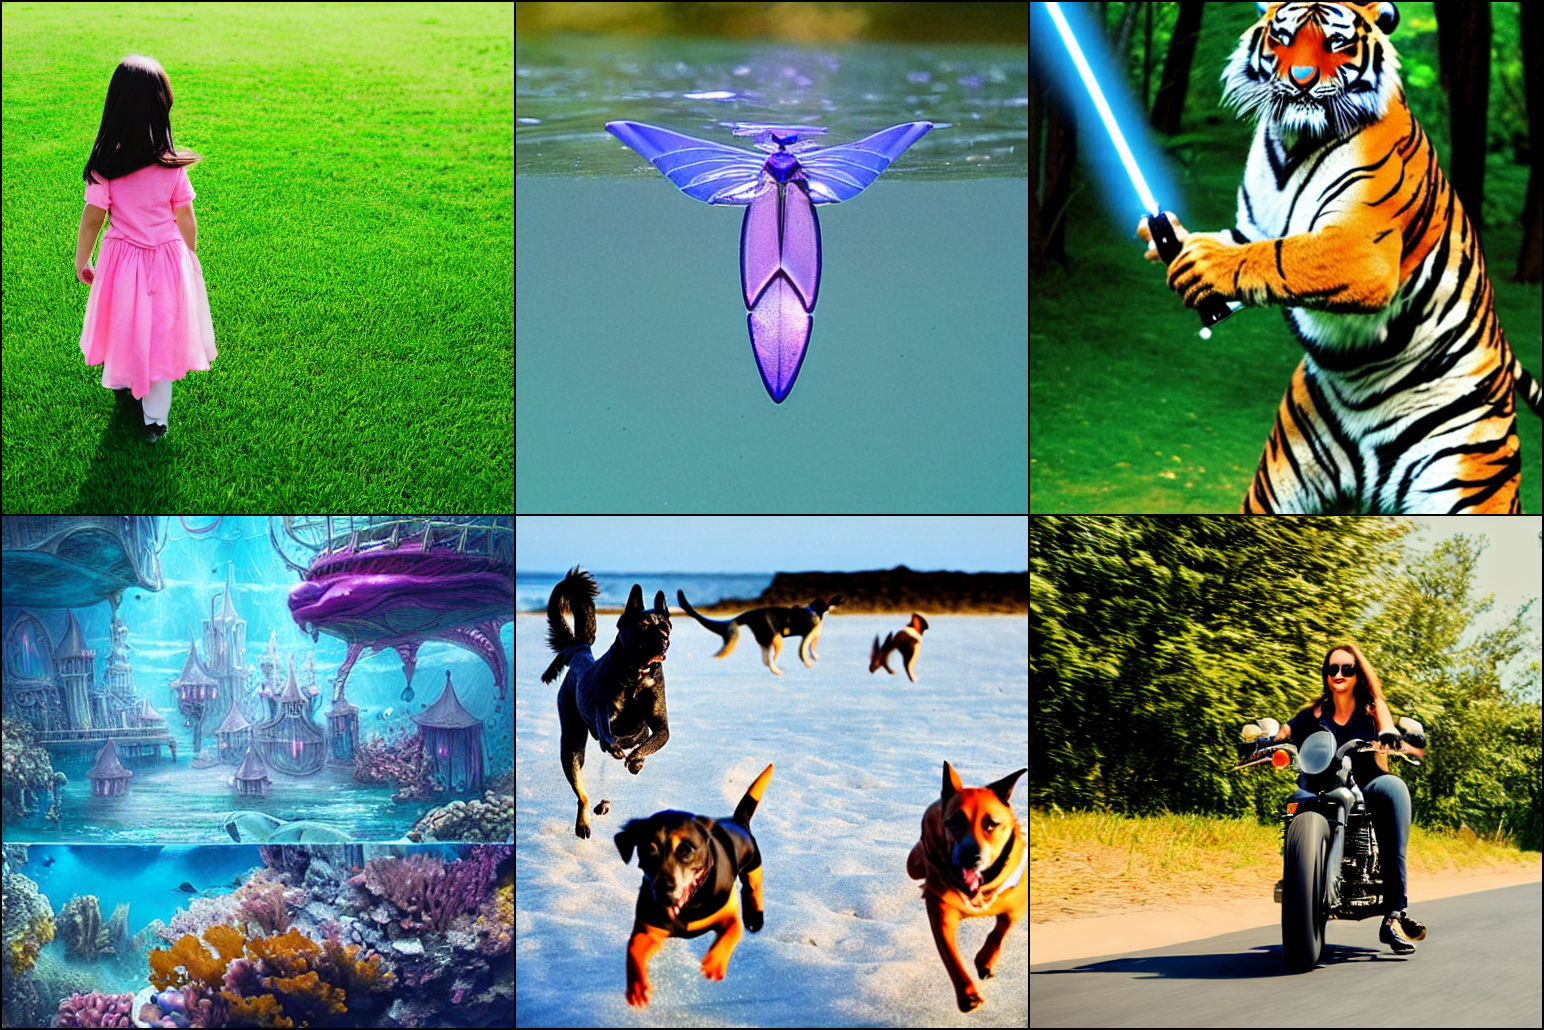

In [18]:
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

grid=make_grid(torch.clip(images/2+0.5,0,1),
               nrow=config.cols)
img=F.to_pil_image(grid)
img.save("files/final_images.png")
img

The images have high resolution and match the text descriptions. You can experiment with various hyperparameters such as the guidance scale parameter, number of inference steps and so on. 